# Lesson 5: Leveraging Assistants API for SQL Databases

## Setup

In [1]:
from openai import AzureOpenAI
import json
import os

## Import the helper function

To access the ``Helper.py`` file, please go to the ``File`` menu and select ``Open...``.

In [2]:
import Helper
from Helper import get_positive_cases_for_state_on_date
from Helper import get_hospitalized_increase_for_state_on_date

## Launch the Assistant API

**Note**: The pre-configured cloud resource grants you access to the Azure OpenAI GPT model. The key and endpoint provided below are intended for teaching purposes only. Your notebook environment is already set up with the necessary keys, which may differ from those used by the instructor during the filming.

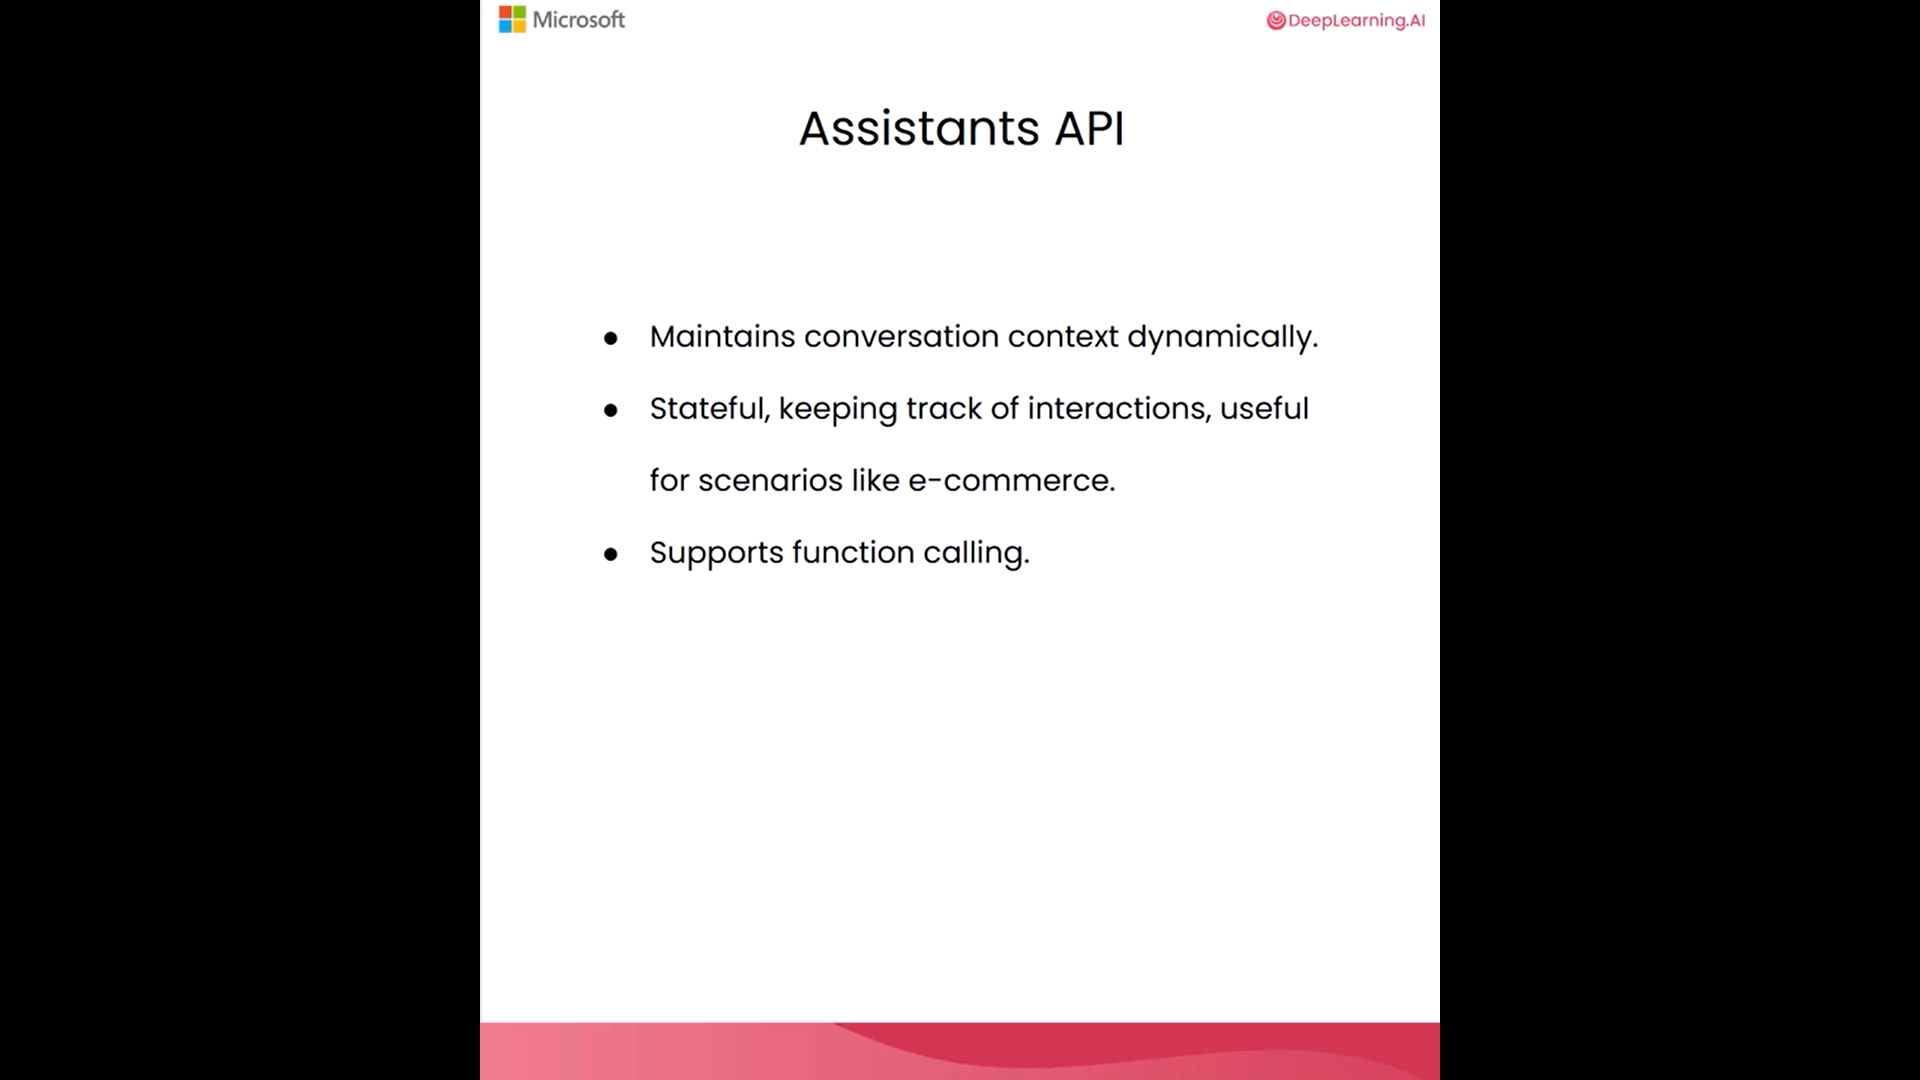

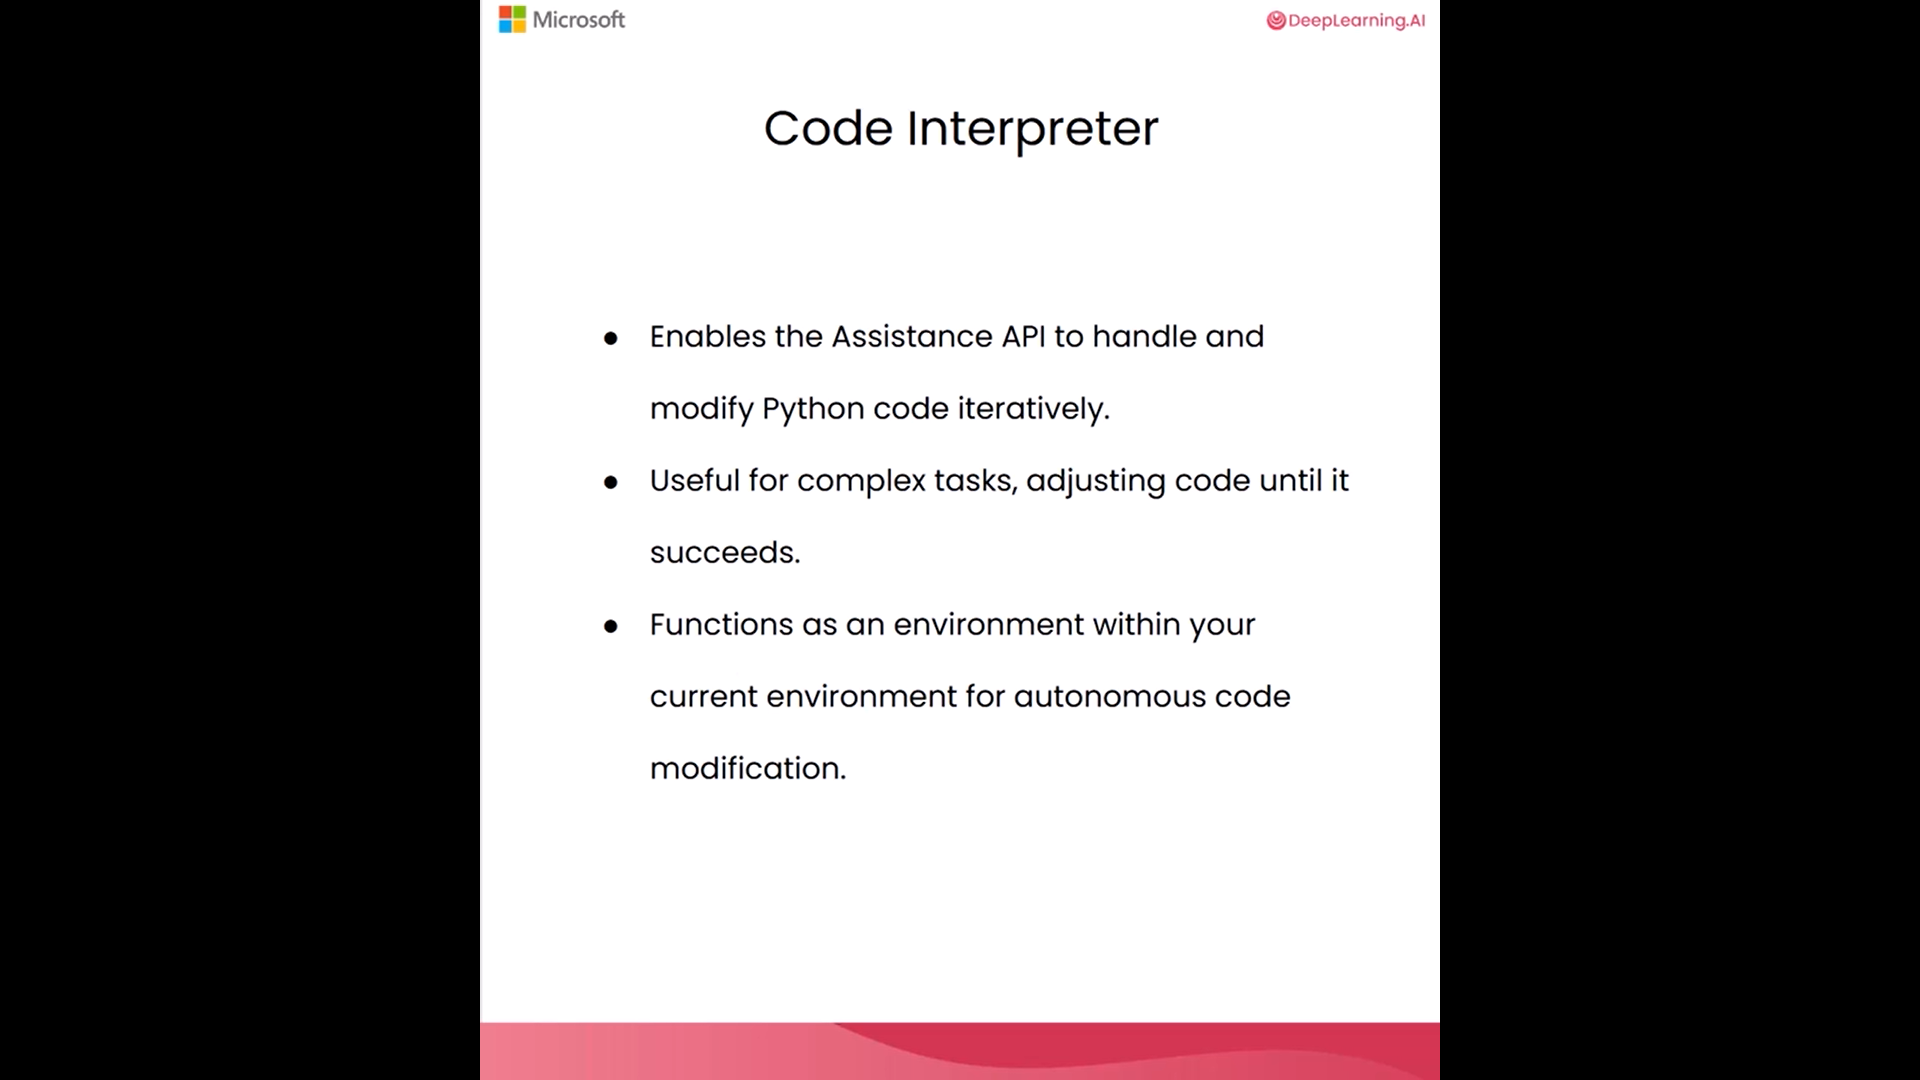

In [ ]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-15-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

# I) Create assistant
assistant = client.beta.assistants.create(
  instructions="""You are an assistant answering questions 
                  about a Covid dataset.""",
  model="gpt-4-1106", 
  tools=Helper.tools_sql)

# II) Create thread
thread = client.beta.threads.create()
print(thread)

In [ ]:
# III) Add message
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""how many hospitalized people we had in Alaska
               the 2021-03-05?"""
)
print(message)

In [ ]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

In [ ]:
# IV) Run assistant on thread

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

## Leverage the function calling with Assistants API

In [ ]:
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,run_id=run.id
    )
    print("Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60),
        int((time.time() - start_time) % 60))
         )
    status = run.status
    print(f'Status: {status}')
    if (status=="requires_action"):
        available_functions = {
            "get_positive_cases_for_state_on_date": get_positive_cases_for_state_on_date,
            "get_hospitalized_increase_for_state_on_date":get_hospitalized_increase_for_state_on_date
        }

        tool_outputs = []
        for tool_call in run.required_action.submit_tool_outputs.tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                state_abbr=function_args.get("state_abbr"),
                specific_date=function_args.get("specific_date"),
            )
            print(function_response)
            print(tool_call.id)
            tool_outputs.append(
                { "tool_call_id": tool_call.id,
                 "output": str(function_response)
                }
            )

        run = client.beta.threads.runs.submit_tool_outputs(
          thread_id=thread.id,
          run_id=run.id,
          tool_outputs = tool_outputs
        )


messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages)

In [ ]:
print(messages.model_dump_json(indent=2))

## Add the code interpreter

In [ ]:
file = client.files.create(
  file=open("./data/all-states-history.csv", "rb"),
  purpose='assistants'
)
assistant = client.beta.assistants.create(
  instructions="""You are an assitant answering questions about
                  a Covid dataset.""",
  model="gpt-4-1106", 
  tools=[{"type": "code_interpreter"}], ##CODE INTERPRETER
  file_ids=[file.id])
thread = client.beta.threads.create()
print(thread)
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""how many hospitalized people we had in Alaska
               the 2021-03-05?"""
)
print(message)
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

In [ ]:
status = run.status
start_time = time.time()
while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    print("Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60),
        int((time.time() - start_time) % 60))
         )
    status = run.status
    print(f'Status: {status}')
    clear_output(wait=True)


messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))